<a href="https://colab.research.google.com/github/kellysolow/titanic_gpt2_fine_tuned/blob/main/kill'em_with_the_love.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import (AutoTokenizer, AutoModelForCausalLM, AdamW, get_scheduler,GPT2Config,
                          GPT2ForSequenceClassification, get_cosine_with_hard_restarts_schedule_with_warmup)
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from datetime import date, timedelta

import torch
import os
import math
import pandas as pd
import numpy as np
import re
import datetime as dt
import random
import matplotlib.pyplot as plt
import logging
import datetime as dt

In [ ]:
class Config:
  epochs = 200
  learning_rate = 0.026
  eps = 1e-8
  weight_decay = 0
  batch_size = 8
  cycles = 9
def seed_everything(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

args = Config()
seed_everything(69)

maxlength = 40
pclass = 'seat class'
sibsp = 'with sibling'
parch = 'parents onboard'
cabin = 'cabin number'
embarked = 'embarked port'
path = './drive/MyDrive/kaggle/titanic'
today = date.today()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device : ", device)

using device :  cuda:0


In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

file_handler = logging.FileHandler(f'{path}/log/gpt2.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
df = pd.read_csv(f"{path}/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
#PClass   94
# SibSp     95
# Parch     96
# Cabin  97
# Embarked 98
# Survived 99



In [ ]:
class titanicDataset(Dataset):
  def __init__(self, use_tokenizer):
    self.dfInput = []
    self.dfOutput = []
    for i in range(len(df['Name'])):
      # txt = (pclass+ str(df["Pclass"][i])+"name" + str(df['Name'][i]) +"sex"+ str(df['Sex'][i])+"age" + str(df['Age'][i]) + sibsp+ str(df["SibSp"][i])+ parch 
      #  +str(df["Parch"][i])+ "ticket" + str(df['Ticket'][i])+"fare"+ str(df['Fare'][i])+cabin+ str(df["Cabin"][i])+embarked+ str(df["Embarked"][i]))
      txt = (pclass+ str(df["Pclass"][i])+"sex"+ str(df['Sex'][i])+"age" + str(df['Age'][i]) + sibsp+ str(df["SibSp"][i])+ parch 
       +str(df["Parch"][i])+ "ticket" + str(df['Ticket'][i])+"fare"+ str(df['Fare'][i])+cabin+ str(df["Cabin"][i])+embarked+ str(df["Embarked"][i]))
      self.dfInput.append(txt)
    for i in df['Survived']:
      self.dfOutput.append(i)

    self.n_examples = len(self.dfOutput)

    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self,item):
    return {'text': self.dfInput[item], 'label': self.dfOutput[item]}

dataDictionary = titanicDataset(use_tokenizer = tokenizer)

In [ ]:
intent2id = {}
intent2id.update({"died":0})
intent2id.update({"alive":1})


In [ ]:
class Gpt2ClassificationCollator(object):
  def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
    self.use_tokenizer = use_tokenizer
    self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
    self.labels_encoder = labels_encoder

  def __call__(self, sequences):
    texts = [sequence['text'] for sequence in sequences]
    labels = [sequence['label'] for sequence in sequences]
    #labels = [self.labels_encoder[label] for label in labels]

    inputs = self.use_tokenizer(text = texts, return_tensors="pt", max_length = self.max_sequence_len, padding = 'max_length', truncation=True).to(device)
    inputs.update({'labels':torch.tensor(labels)})

    return inputs

In [ ]:
collator = Gpt2ClassificationCollator(use_tokenizer = tokenizer, labels_encoder = intent2id, max_sequence_len = maxlength,)
dataloader = DataLoader (dataDictionary , batch_size = args.batch_size, collate_fn =collator, shuffle = True)

In [ ]:
#model_config = GPT2Config.from_pretrained('gpt2', num_labels = 2)

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels = 2)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print("model loaded")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model loaded


In [ ]:
torch.nn.init.kaiming_uniform_(model.score.weight)

Parameter containing:
tensor([[-0.0443, -0.0625,  0.0187,  ..., -0.0548,  0.0346, -0.0025],
        [ 0.0882,  0.0105,  0.0693,  ...,  0.0338, -0.0367, -0.0698]],
       device='cuda:0', requires_grad=True)

In [ ]:
optimizer_grouped_parameters = [
    {
        "params" : [p for n, p in model.named_parameters()],
        "weight_decay" : args.weight_decay,
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr = args.learning_rate)

cosineannealing_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = len(dataloader)*args.epochs/10,
    num_training_steps = len(dataloader)*args.epochs,
    num_cycles= args.cycles
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train (dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.train()

  for batch in tqdm(dataloader, total = len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    model.zero_grad()

    outputs = model(**batch)

    loss = outputs.loss
    logits = outputs.logits

    loss.backward()

    total_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer_.step()
    scheduler_.step()

    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
  
  logger.info("current lr")
  logger.info(scheduler_.get_last_lr())



  avg_epoch_loss = total_loss/len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss



training on batchs .. 0/200


100%|██████████| 112/112 [00:11<00:00,  9.92it/s]
INFO:root:current lr
2022-09-22 00:05:14,100 - root - INFO - current lr
INFO:root:[0.0013]
2022-09-22 00:05:14,105 - root - INFO - [0.0013]
INFO:root:train_loss: 0.99913 - train_acc:0.57239
2022-09-22 00:05:14,118 - root - INFO - train_loss: 0.99913 - train_acc:0.57239


training on batchs .. 1/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:05:23,346 - root - INFO - current lr
INFO:root:[0.0026]
2022-09-22 00:05:23,349 - root - INFO - [0.0026]
INFO:root:train_loss: 0.68204 - train_acc:0.64085
2022-09-22 00:05:23,358 - root - INFO - train_loss: 0.68204 - train_acc:0.64085


training on batchs .. 2/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:05:32,596 - root - INFO - current lr
INFO:root:[0.0039]
2022-09-22 00:05:32,601 - root - INFO - [0.0039]
INFO:root:train_loss: 0.64010 - train_acc:0.69248
2022-09-22 00:05:32,610 - root - INFO - train_loss: 0.64010 - train_acc:0.69248


training on batchs .. 3/200


100%|██████████| 112/112 [00:09<00:00, 12.10it/s]
INFO:root:current lr
2022-09-22 00:05:41,885 - root - INFO - current lr
INFO:root:[0.0052]
2022-09-22 00:05:41,889 - root - INFO - [0.0052]
INFO:root:train_loss: 0.62568 - train_acc:0.73850
2022-09-22 00:05:41,900 - root - INFO - train_loss: 0.62568 - train_acc:0.73850


training on batchs .. 4/200


100%|██████████| 112/112 [00:09<00:00, 11.39it/s]
INFO:root:current lr
2022-09-22 00:05:51,747 - root - INFO - current lr
INFO:root:[0.0065]
2022-09-22 00:05:51,752 - root - INFO - [0.0065]
INFO:root:train_loss: 0.67393 - train_acc:0.71044
2022-09-22 00:05:51,761 - root - INFO - train_loss: 0.67393 - train_acc:0.71044


training on batchs .. 5/200


100%|██████████| 112/112 [00:09<00:00, 12.14it/s]
INFO:root:current lr
2022-09-22 00:06:01,000 - root - INFO - current lr
INFO:root:[0.0078]
2022-09-22 00:06:01,005 - root - INFO - [0.0078]
INFO:root:train_loss: 0.69484 - train_acc:0.67789
2022-09-22 00:06:01,015 - root - INFO - train_loss: 0.69484 - train_acc:0.67789


training on batchs .. 6/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:06:10,191 - root - INFO - current lr
INFO:root:[0.009099999999999999]
2022-09-22 00:06:10,194 - root - INFO - [0.009099999999999999]
INFO:root:train_loss: 0.64839 - train_acc:0.71156
2022-09-22 00:06:10,205 - root - INFO - train_loss: 0.64839 - train_acc:0.71156


training on batchs .. 7/200


100%|██████████| 112/112 [00:09<00:00, 12.09it/s]
INFO:root:current lr
2022-09-22 00:06:19,480 - root - INFO - current lr
INFO:root:[0.0104]
2022-09-22 00:06:19,485 - root - INFO - [0.0104]
INFO:root:train_loss: 0.88429 - train_acc:0.62963
2022-09-22 00:06:19,497 - root - INFO - train_loss: 0.88429 - train_acc:0.62963


training on batchs .. 8/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:06:28,744 - root - INFO - current lr
INFO:root:[0.0117]
2022-09-22 00:06:28,747 - root - INFO - [0.0117]
INFO:root:train_loss: 0.68922 - train_acc:0.67003
2022-09-22 00:06:28,754 - root - INFO - train_loss: 0.68922 - train_acc:0.67003


training on batchs .. 9/200


100%|██████████| 112/112 [00:09<00:00, 12.04it/s]
INFO:root:current lr
2022-09-22 00:06:38,071 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:06:38,078 - root - INFO - [0.013]
INFO:root:train_loss: 0.72250 - train_acc:0.64310
2022-09-22 00:06:38,084 - root - INFO - train_loss: 0.72250 - train_acc:0.64310


training on batchs .. 10/200


100%|██████████| 112/112 [00:09<00:00, 12.12it/s]
INFO:root:current lr
2022-09-22 00:06:47,345 - root - INFO - current lr
INFO:root:[0.0143]
2022-09-22 00:06:47,349 - root - INFO - [0.0143]
INFO:root:train_loss: 0.86642 - train_acc:0.58586
2022-09-22 00:06:47,359 - root - INFO - train_loss: 0.86642 - train_acc:0.58586


training on batchs .. 11/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:06:56,557 - root - INFO - current lr
INFO:root:[0.0156]
2022-09-22 00:06:56,561 - root - INFO - [0.0156]
INFO:root:train_loss: 0.82883 - train_acc:0.58586
2022-09-22 00:06:56,570 - root - INFO - train_loss: 0.82883 - train_acc:0.58586


training on batchs .. 12/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:07:05,728 - root - INFO - current lr
INFO:root:[0.0169]
2022-09-22 00:07:05,732 - root - INFO - [0.0169]
INFO:root:train_loss: 0.73685 - train_acc:0.60606
2022-09-22 00:07:05,738 - root - INFO - train_loss: 0.73685 - train_acc:0.60606


training on batchs .. 13/200


100%|██████████| 112/112 [00:09<00:00, 12.05it/s]
INFO:root:current lr
2022-09-22 00:07:15,049 - root - INFO - current lr
INFO:root:[0.018199999999999997]
2022-09-22 00:07:15,055 - root - INFO - [0.018199999999999997]
INFO:root:train_loss: 0.62591 - train_acc:0.69921
2022-09-22 00:07:15,065 - root - INFO - train_loss: 0.62591 - train_acc:0.69921


training on batchs .. 14/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:07:24,263 - root - INFO - current lr
INFO:root:[0.0195]
2022-09-22 00:07:24,267 - root - INFO - [0.0195]
INFO:root:train_loss: 0.68828 - train_acc:0.69921
2022-09-22 00:07:24,276 - root - INFO - train_loss: 0.68828 - train_acc:0.69921


training on batchs .. 15/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:07:33,537 - root - INFO - current lr
INFO:root:[0.0208]
2022-09-22 00:07:33,544 - root - INFO - [0.0208]
INFO:root:train_loss: 0.64148 - train_acc:0.71605
2022-09-22 00:07:33,555 - root - INFO - train_loss: 0.64148 - train_acc:0.71605


training on batchs .. 16/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:07:42,816 - root - INFO - current lr
INFO:root:[0.022099999999999998]
2022-09-22 00:07:42,820 - root - INFO - [0.022099999999999998]
INFO:root:train_loss: 0.68167 - train_acc:0.72503
2022-09-22 00:07:42,831 - root - INFO - train_loss: 0.68167 - train_acc:0.72503


training on batchs .. 17/200


100%|██████████| 112/112 [00:09<00:00, 12.12it/s]
INFO:root:current lr
2022-09-22 00:07:52,083 - root - INFO - current lr
INFO:root:[0.0234]
2022-09-22 00:07:52,087 - root - INFO - [0.0234]
INFO:root:train_loss: 0.65558 - train_acc:0.68126
2022-09-22 00:07:52,097 - root - INFO - train_loss: 0.65558 - train_acc:0.68126


training on batchs .. 18/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:08:01,240 - root - INFO - current lr
INFO:root:[0.024699999999999996]
2022-09-22 00:08:01,243 - root - INFO - [0.024699999999999996]
INFO:root:train_loss: 0.57412 - train_acc:0.73401
2022-09-22 00:08:01,253 - root - INFO - train_loss: 0.57412 - train_acc:0.73401


training on batchs .. 19/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:08:10,451 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:08:10,458 - root - INFO - [0.026]
INFO:root:train_loss: 0.58311 - train_acc:0.75982
2022-09-22 00:08:10,468 - root - INFO - train_loss: 0.58311 - train_acc:0.75982


training on batchs .. 20/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:08:19,715 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:08:19,721 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.55787 - train_acc:0.74747
2022-09-22 00:08:19,729 - root - INFO - train_loss: 0.55787 - train_acc:0.74747


training on batchs .. 21/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:08:28,869 - root - INFO - current lr
INFO:root:[0.025363734711836994]
2022-09-22 00:08:28,873 - root - INFO - [0.025363734711836994]
INFO:root:train_loss: 0.50620 - train_acc:0.78451
2022-09-22 00:08:28,884 - root - INFO - train_loss: 0.50620 - train_acc:0.78451


training on batchs .. 22/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:08:38,058 - root - INFO - current lr
INFO:root:[0.02458308481444878]
2022-09-22 00:08:38,062 - root - INFO - [0.02458308481444878]
INFO:root:train_loss: 0.52589 - train_acc:0.79574
2022-09-22 00:08:38,071 - root - INFO - train_loss: 0.52589 - train_acc:0.79574


training on batchs .. 23/200


100%|██████████| 112/112 [00:09<00:00, 12.05it/s]
INFO:root:current lr
2022-09-22 00:08:47,377 - root - INFO - current lr
INFO:root:[0.023517220926874315]
2022-09-22 00:08:47,381 - root - INFO - [0.023517220926874315]
INFO:root:train_loss: 0.49063 - train_acc:0.80471
2022-09-22 00:08:47,393 - root - INFO - train_loss: 0.49063 - train_acc:0.80471


training on batchs .. 24/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:08:56,553 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:08:56,557 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.49127 - train_acc:0.81930
2022-09-22 00:08:56,569 - root - INFO - train_loss: 0.49127 - train_acc:0.81930


training on batchs .. 25/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:09:05,748 - root - INFO - current lr
INFO:root:[0.02064120827980215]
2022-09-22 00:09:05,753 - root - INFO - [0.02064120827980215]
INFO:root:train_loss: 0.45506 - train_acc:0.81145
2022-09-22 00:09:05,763 - root - INFO - train_loss: 0.45506 - train_acc:0.81145


training on batchs .. 26/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:09:14,966 - root - INFO - current lr
INFO:root:[0.018901876496614105]
2022-09-22 00:09:14,971 - root - INFO - [0.018901876496614105]
INFO:root:train_loss: 0.40614 - train_acc:0.84287
2022-09-22 00:09:14,983 - root - INFO - train_loss: 0.40614 - train_acc:0.84287


training on batchs .. 27/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:09:24,127 - root - INFO - current lr
INFO:root:[0.017017220926874316]
2022-09-22 00:09:24,131 - root - INFO - [0.017017220926874316]
INFO:root:train_loss: 0.38856 - train_acc:0.84961
2022-09-22 00:09:24,142 - root - INFO - train_loss: 0.38856 - train_acc:0.84961


training on batchs .. 28/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:09:33,300 - root - INFO - current lr
INFO:root:[0.015033648045523002]
2022-09-22 00:09:33,304 - root - INFO - [0.015033648045523002]
INFO:root:train_loss: 0.39367 - train_acc:0.82716
2022-09-22 00:09:33,309 - root - INFO - train_loss: 0.39367 - train_acc:0.82716


training on batchs .. 29/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:09:42,443 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:09:42,447 - root - INFO - [0.013]
INFO:root:train_loss: 0.36442 - train_acc:0.85073
2022-09-22 00:09:42,456 - root - INFO - train_loss: 0.36442 - train_acc:0.85073


training on batchs .. 30/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:09:51,688 - root - INFO - current lr
INFO:root:[0.010966351954477002]
2022-09-22 00:09:51,692 - root - INFO - [0.010966351954477002]
INFO:root:train_loss: 0.37712 - train_acc:0.84848
2022-09-22 00:09:51,700 - root - INFO - train_loss: 0.37712 - train_acc:0.84848


training on batchs .. 31/200


100%|██████████| 112/112 [00:09<00:00, 12.05it/s]
INFO:root:current lr
2022-09-22 00:10:01,010 - root - INFO - current lr
INFO:root:[0.008982779073125684]
2022-09-22 00:10:01,013 - root - INFO - [0.008982779073125684]
INFO:root:train_loss: 0.35268 - train_acc:0.86644
2022-09-22 00:10:01,024 - root - INFO - train_loss: 0.35268 - train_acc:0.86644


training on batchs .. 32/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:10:10,222 - root - INFO - current lr
INFO:root:[0.007098123503385898]
2022-09-22 00:10:10,226 - root - INFO - [0.007098123503385898]
INFO:root:train_loss: 0.35212 - train_acc:0.85634
2022-09-22 00:10:10,235 - root - INFO - train_loss: 0.35212 - train_acc:0.85634


training on batchs .. 33/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:10:19,414 - root - INFO - current lr
INFO:root:[0.00535879172019785]
2022-09-22 00:10:19,421 - root - INFO - [0.00535879172019785]
INFO:root:train_loss: 0.32644 - train_acc:0.86981
2022-09-22 00:10:19,428 - root - INFO - train_loss: 0.32644 - train_acc:0.86981


training on batchs .. 34/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:10:28,599 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:10:28,603 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.31890 - train_acc:0.86420
2022-09-22 00:10:28,609 - root - INFO - train_loss: 0.31890 - train_acc:0.86420


training on batchs .. 35/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:10:37,800 - root - INFO - current lr
INFO:root:[0.0024827790731256844]
2022-09-22 00:10:37,804 - root - INFO - [0.0024827790731256844]
INFO:root:train_loss: 0.30772 - train_acc:0.87991
2022-09-22 00:10:37,815 - root - INFO - train_loss: 0.30772 - train_acc:0.87991


training on batchs .. 36/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:10:47,019 - root - INFO - current lr
INFO:root:[0.0014169151855512186]
2022-09-22 00:10:47,024 - root - INFO - [0.0014169151855512186]
INFO:root:train_loss: 0.30737 - train_acc:0.88103
2022-09-22 00:10:47,036 - root - INFO - train_loss: 0.30737 - train_acc:0.88103


training on batchs .. 37/200


100%|██████████| 112/112 [00:09<00:00, 11.94it/s]
INFO:root:current lr
2022-09-22 00:10:56,432 - root - INFO - current lr
INFO:root:[0.0006362652881630041]
2022-09-22 00:10:56,436 - root - INFO - [0.0006362652881630041]
INFO:root:train_loss: 0.30078 - train_acc:0.87205
2022-09-22 00:10:56,445 - root - INFO - train_loss: 0.30078 - train_acc:0.87205


training on batchs .. 38/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:11:05,716 - root - INFO - current lr
INFO:root:[0.00016005157226321043]
2022-09-22 00:11:05,720 - root - INFO - [0.00016005157226321043]
INFO:root:train_loss: 0.29404 - train_acc:0.87430
2022-09-22 00:11:05,730 - root - INFO - train_loss: 0.29404 - train_acc:0.87430


training on batchs .. 39/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:11:14,908 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:11:14,913 - root - INFO - [0.026]
INFO:root:train_loss: 0.29636 - train_acc:0.87767
2022-09-22 00:11:14,925 - root - INFO - train_loss: 0.29636 - train_acc:0.87767


training on batchs .. 40/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:11:24,071 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:11:24,075 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.44311 - train_acc:0.83389
2022-09-22 00:11:24,084 - root - INFO - train_loss: 0.44311 - train_acc:0.83389


training on batchs .. 41/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:11:33,299 - root - INFO - current lr
INFO:root:[0.025363734711836994]
2022-09-22 00:11:33,302 - root - INFO - [0.025363734711836994]
INFO:root:train_loss: 0.48279 - train_acc:0.81818
2022-09-22 00:11:33,314 - root - INFO - train_loss: 0.48279 - train_acc:0.81818


training on batchs .. 42/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:11:42,465 - root - INFO - current lr
INFO:root:[0.024583084814448784]
2022-09-22 00:11:42,469 - root - INFO - [0.024583084814448784]
INFO:root:train_loss: 0.47002 - train_acc:0.79910
2022-09-22 00:11:42,481 - root - INFO - train_loss: 0.47002 - train_acc:0.79910


training on batchs .. 43/200


100%|██████████| 112/112 [00:09<00:00, 12.12it/s]
INFO:root:current lr
2022-09-22 00:11:51,736 - root - INFO - current lr
INFO:root:[0.023517220926874315]
2022-09-22 00:11:51,741 - root - INFO - [0.023517220926874315]
INFO:root:train_loss: 0.37765 - train_acc:0.84175
2022-09-22 00:11:51,753 - root - INFO - train_loss: 0.37765 - train_acc:0.84175


training on batchs .. 44/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:12:00,965 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:12:00,969 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.35353 - train_acc:0.84848
2022-09-22 00:12:00,976 - root - INFO - train_loss: 0.35353 - train_acc:0.84848


training on batchs .. 45/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:12:10,148 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:12:10,152 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.39656 - train_acc:0.84848
2022-09-22 00:12:10,162 - root - INFO - train_loss: 0.39656 - train_acc:0.84848


training on batchs .. 46/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:12:19,379 - root - INFO - current lr
INFO:root:[0.018901876496614112]
2022-09-22 00:12:19,383 - root - INFO - [0.018901876496614112]
INFO:root:train_loss: 0.31080 - train_acc:0.87205
2022-09-22 00:12:19,392 - root - INFO - train_loss: 0.31080 - train_acc:0.87205


training on batchs .. 47/200


100%|██████████| 112/112 [00:09<00:00, 12.04it/s]
INFO:root:current lr
2022-09-22 00:12:28,705 - root - INFO - current lr
INFO:root:[0.01701722092687432]
2022-09-22 00:12:28,712 - root - INFO - [0.01701722092687432]
INFO:root:train_loss: 0.33863 - train_acc:0.85971
2022-09-22 00:12:28,721 - root - INFO - train_loss: 0.33863 - train_acc:0.85971


training on batchs .. 48/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:12:37,930 - root - INFO - current lr
INFO:root:[0.015033648045522994]
2022-09-22 00:12:37,935 - root - INFO - [0.015033648045522994]
INFO:root:train_loss: 0.28476 - train_acc:0.88328
2022-09-22 00:12:37,945 - root - INFO - train_loss: 0.28476 - train_acc:0.88328


training on batchs .. 49/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:12:47,178 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:12:47,184 - root - INFO - [0.013]
INFO:root:train_loss: 0.28385 - train_acc:0.88328
2022-09-22 00:12:47,197 - root - INFO - train_loss: 0.28385 - train_acc:0.88328


training on batchs .. 50/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:12:56,381 - root - INFO - current lr
INFO:root:[0.010966351954476995]
2022-09-22 00:12:56,387 - root - INFO - [0.010966351954476995]
INFO:root:train_loss: 0.27669 - train_acc:0.87991
2022-09-22 00:12:56,397 - root - INFO - train_loss: 0.27669 - train_acc:0.87991


training on batchs .. 51/200


100%|██████████| 112/112 [00:09<00:00, 12.04it/s]
INFO:root:current lr
2022-09-22 00:13:05,717 - root - INFO - current lr
INFO:root:[0.00898277907312568]
2022-09-22 00:13:05,720 - root - INFO - [0.00898277907312568]
INFO:root:train_loss: 0.26454 - train_acc:0.87542
2022-09-22 00:13:05,730 - root - INFO - train_loss: 0.26454 - train_acc:0.87542


training on batchs .. 52/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:13:14,990 - root - INFO - current lr
INFO:root:[0.007098123503385898]
2022-09-22 00:13:14,998 - root - INFO - [0.007098123503385898]
INFO:root:train_loss: 0.25288 - train_acc:0.89001
2022-09-22 00:13:15,004 - root - INFO - train_loss: 0.25288 - train_acc:0.89001


training on batchs .. 53/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:13:24,215 - root - INFO - current lr
INFO:root:[0.00535879172019785]
2022-09-22 00:13:24,219 - root - INFO - [0.00535879172019785]
INFO:root:train_loss: 0.25213 - train_acc:0.89226
2022-09-22 00:13:24,231 - root - INFO - train_loss: 0.25213 - train_acc:0.89226


training on batchs .. 54/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:13:33,380 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:13:33,384 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.24475 - train_acc:0.89001
2022-09-22 00:13:33,395 - root - INFO - train_loss: 0.24475 - train_acc:0.89001


training on batchs .. 55/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:13:42,527 - root - INFO - current lr
INFO:root:[0.0024827790731256844]
2022-09-22 00:13:42,531 - root - INFO - [0.0024827790731256844]
INFO:root:train_loss: 0.22927 - train_acc:0.90909
2022-09-22 00:13:42,543 - root - INFO - train_loss: 0.22927 - train_acc:0.90909


training on batchs .. 56/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:13:51,699 - root - INFO - current lr
INFO:root:[0.0014169151855512217]
2022-09-22 00:13:51,704 - root - INFO - [0.0014169151855512217]
INFO:root:train_loss: 0.21403 - train_acc:0.91695
2022-09-22 00:13:51,710 - root - INFO - train_loss: 0.21403 - train_acc:0.91695


training on batchs .. 57/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:14:00,911 - root - INFO - current lr
INFO:root:[0.0006362652881630055]
2022-09-22 00:14:00,917 - root - INFO - [0.0006362652881630055]
INFO:root:train_loss: 0.22229 - train_acc:0.90123
2022-09-22 00:14:00,931 - root - INFO - train_loss: 0.22229 - train_acc:0.90123


training on batchs .. 58/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:14:10,092 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:14:10,096 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.21659 - train_acc:0.91021
2022-09-22 00:14:10,107 - root - INFO - train_loss: 0.21659 - train_acc:0.91021


training on batchs .. 59/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:14:19,324 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:14:19,329 - root - INFO - [0.026]
INFO:root:train_loss: 0.21428 - train_acc:0.91134
2022-09-22 00:14:19,338 - root - INFO - train_loss: 0.21428 - train_acc:0.91134


training on batchs .. 60/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:14:28,583 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:14:28,589 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.43601 - train_acc:0.85522
2022-09-22 00:14:28,599 - root - INFO - train_loss: 0.43601 - train_acc:0.85522


training on batchs .. 61/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:14:37,778 - root - INFO - current lr
INFO:root:[0.025363734711836994]
2022-09-22 00:14:37,785 - root - INFO - [0.025363734711836994]
INFO:root:train_loss: 0.44967 - train_acc:0.85410
2022-09-22 00:14:37,794 - root - INFO - train_loss: 0.44967 - train_acc:0.85410


training on batchs .. 62/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:14:46,964 - root - INFO - current lr
INFO:root:[0.024583084814448784]
2022-09-22 00:14:46,969 - root - INFO - [0.024583084814448784]
INFO:root:train_loss: 0.35881 - train_acc:0.86981
2022-09-22 00:14:46,979 - root - INFO - train_loss: 0.35881 - train_acc:0.86981


training on batchs .. 63/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:14:56,148 - root - INFO - current lr
INFO:root:[0.023517220926874322]
2022-09-22 00:14:56,151 - root - INFO - [0.023517220926874322]
INFO:root:train_loss: 0.44901 - train_acc:0.84624
2022-09-22 00:14:56,163 - root - INFO - train_loss: 0.44901 - train_acc:0.84624


training on batchs .. 64/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:15:05,334 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:15:05,341 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.34087 - train_acc:0.85971
2022-09-22 00:15:05,351 - root - INFO - train_loss: 0.34087 - train_acc:0.85971


training on batchs .. 65/200


100%|██████████| 112/112 [00:09<00:00, 12.05it/s]
INFO:root:current lr
2022-09-22 00:15:14,660 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:15:14,664 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.28443 - train_acc:0.89338
2022-09-22 00:15:14,673 - root - INFO - train_loss: 0.28443 - train_acc:0.89338


training on batchs .. 66/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:15:23,864 - root - INFO - current lr
INFO:root:[0.018901876496614105]
2022-09-22 00:15:23,870 - root - INFO - [0.018901876496614105]
INFO:root:train_loss: 0.30471 - train_acc:0.87654
2022-09-22 00:15:23,878 - root - INFO - train_loss: 0.30471 - train_acc:0.87654


training on batchs .. 67/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:15:33,029 - root - INFO - current lr
INFO:root:[0.01701722092687432]
2022-09-22 00:15:33,036 - root - INFO - [0.01701722092687432]
INFO:root:train_loss: 0.28162 - train_acc:0.88328
2022-09-22 00:15:33,046 - root - INFO - train_loss: 0.28162 - train_acc:0.88328


training on batchs .. 68/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:15:42,224 - root - INFO - current lr
INFO:root:[0.015033648045523013]
2022-09-22 00:15:42,233 - root - INFO - [0.015033648045523013]
INFO:root:train_loss: 0.28689 - train_acc:0.88103
2022-09-22 00:15:42,240 - root - INFO - train_loss: 0.28689 - train_acc:0.88103


training on batchs .. 69/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:15:51,424 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:15:51,428 - root - INFO - [0.013]
INFO:root:train_loss: 0.27286 - train_acc:0.88889
2022-09-22 00:15:51,437 - root - INFO - train_loss: 0.27286 - train_acc:0.88889


training on batchs .. 70/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:16:00,592 - root - INFO - current lr
INFO:root:[0.010966351954477007]
2022-09-22 00:16:00,595 - root - INFO - [0.010966351954477007]
INFO:root:train_loss: 0.25174 - train_acc:0.90572
2022-09-22 00:16:00,604 - root - INFO - train_loss: 0.25174 - train_acc:0.90572


training on batchs .. 71/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:16:09,808 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:16:09,812 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.24858 - train_acc:0.89338
2022-09-22 00:16:09,824 - root - INFO - train_loss: 0.24858 - train_acc:0.89338


training on batchs .. 72/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:16:19,022 - root - INFO - current lr
INFO:root:[0.007098123503385898]
2022-09-22 00:16:19,027 - root - INFO - [0.007098123503385898]
INFO:root:train_loss: 0.23879 - train_acc:0.90460
2022-09-22 00:16:19,041 - root - INFO - train_loss: 0.23879 - train_acc:0.90460


training on batchs .. 73/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:16:28,210 - root - INFO - current lr
INFO:root:[0.005358791720197859]
2022-09-22 00:16:28,214 - root - INFO - [0.005358791720197859]
INFO:root:train_loss: 0.22476 - train_acc:0.91246
2022-09-22 00:16:28,225 - root - INFO - train_loss: 0.22476 - train_acc:0.91246


training on batchs .. 74/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:16:37,439 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:16:37,443 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.23145 - train_acc:0.89787
2022-09-22 00:16:37,455 - root - INFO - train_loss: 0.23145 - train_acc:0.89787


training on batchs .. 75/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:16:46,673 - root - INFO - current lr
INFO:root:[0.0024827790731256874]
2022-09-22 00:16:46,680 - root - INFO - [0.0024827790731256874]
INFO:root:train_loss: 0.22346 - train_acc:0.90348
2022-09-22 00:16:46,693 - root - INFO - train_loss: 0.22346 - train_acc:0.90348


training on batchs .. 76/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:16:55,858 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:16:55,864 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.22327 - train_acc:0.90685
2022-09-22 00:16:55,871 - root - INFO - train_loss: 0.22327 - train_acc:0.90685


training on batchs .. 77/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:17:05,058 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:17:05,062 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.20641 - train_acc:0.91807
2022-09-22 00:17:05,076 - root - INFO - train_loss: 0.20641 - train_acc:0.91807


training on batchs .. 78/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:17:14,246 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:17:14,251 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.21418 - train_acc:0.91021
2022-09-22 00:17:14,266 - root - INFO - train_loss: 0.21418 - train_acc:0.91021


training on batchs .. 79/200


100%|██████████| 112/112 [00:09<00:00, 11.91it/s]
INFO:root:current lr
2022-09-22 00:17:23,682 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:17:23,691 - root - INFO - [0.026]
INFO:root:train_loss: 0.19591 - train_acc:0.92368
2022-09-22 00:17:23,698 - root - INFO - train_loss: 0.19591 - train_acc:0.92368


training on batchs .. 80/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:17:32,952 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:17:32,955 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.53905 - train_acc:0.85073
2022-09-22 00:17:32,966 - root - INFO - train_loss: 0.53905 - train_acc:0.85073


training on batchs .. 81/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:17:42,168 - root - INFO - current lr
INFO:root:[0.025363734711836994]
2022-09-22 00:17:42,173 - root - INFO - [0.025363734711836994]
INFO:root:train_loss: 0.46935 - train_acc:0.83614
2022-09-22 00:17:42,186 - root - INFO - train_loss: 0.46935 - train_acc:0.83614


training on batchs .. 82/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:17:51,431 - root - INFO - current lr
INFO:root:[0.024583084814448784]
2022-09-22 00:17:51,435 - root - INFO - [0.024583084814448784]
INFO:root:train_loss: 0.39169 - train_acc:0.85971
2022-09-22 00:17:51,445 - root - INFO - train_loss: 0.39169 - train_acc:0.85971


training on batchs .. 83/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:18:00,666 - root - INFO - current lr
INFO:root:[0.02351722092687431]
2022-09-22 00:18:00,674 - root - INFO - [0.02351722092687431]
INFO:root:train_loss: 0.32255 - train_acc:0.87542
2022-09-22 00:18:00,684 - root - INFO - train_loss: 0.32255 - train_acc:0.87542


training on batchs .. 84/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:18:09,848 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:18:09,851 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.28566 - train_acc:0.89001
2022-09-22 00:18:09,863 - root - INFO - train_loss: 0.28566 - train_acc:0.89001


training on batchs .. 85/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:18:18,998 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:18:19,003 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.30529 - train_acc:0.86756
2022-09-22 00:18:19,011 - root - INFO - train_loss: 0.30529 - train_acc:0.86756


training on batchs .. 86/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:18:28,212 - root - INFO - current lr
INFO:root:[0.018901876496614105]
2022-09-22 00:18:28,216 - root - INFO - [0.018901876496614105]
INFO:root:train_loss: 0.28697 - train_acc:0.88103
2022-09-22 00:18:28,228 - root - INFO - train_loss: 0.28697 - train_acc:0.88103


training on batchs .. 87/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:18:37,431 - root - INFO - current lr
INFO:root:[0.01701722092687432]
2022-09-22 00:18:37,435 - root - INFO - [0.01701722092687432]
INFO:root:train_loss: 0.26700 - train_acc:0.88777
2022-09-22 00:18:37,447 - root - INFO - train_loss: 0.26700 - train_acc:0.88777


training on batchs .. 88/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:18:46,675 - root - INFO - current lr
INFO:root:[0.015033648045522994]
2022-09-22 00:18:46,680 - root - INFO - [0.015033648045522994]
INFO:root:train_loss: 0.26144 - train_acc:0.90011
2022-09-22 00:18:46,695 - root - INFO - train_loss: 0.26144 - train_acc:0.90011


training on batchs .. 89/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:18:55,904 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:18:55,908 - root - INFO - [0.013]
INFO:root:train_loss: 0.26006 - train_acc:0.89675
2022-09-22 00:18:55,917 - root - INFO - train_loss: 0.26006 - train_acc:0.89675


training on batchs .. 90/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:19:05,118 - root - INFO - current lr
INFO:root:[0.010966351954477007]
2022-09-22 00:19:05,123 - root - INFO - [0.010966351954477007]
INFO:root:train_loss: 0.24914 - train_acc:0.89899
2022-09-22 00:19:05,134 - root - INFO - train_loss: 0.24914 - train_acc:0.89899


training on batchs .. 91/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:19:14,368 - root - INFO - current lr
INFO:root:[0.00898277907312568]
2022-09-22 00:19:14,373 - root - INFO - [0.00898277907312568]
INFO:root:train_loss: 0.24869 - train_acc:0.89787
2022-09-22 00:19:14,378 - root - INFO - train_loss: 0.24869 - train_acc:0.89787


training on batchs .. 92/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:19:23,591 - root - INFO - current lr
INFO:root:[0.007098123503385898]
2022-09-22 00:19:23,597 - root - INFO - [0.007098123503385898]
INFO:root:train_loss: 0.22083 - train_acc:0.90685
2022-09-22 00:19:23,611 - root - INFO - train_loss: 0.22083 - train_acc:0.90685


training on batchs .. 93/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:19:32,876 - root - INFO - current lr
INFO:root:[0.005358791720197859]
2022-09-22 00:19:32,879 - root - INFO - [0.005358791720197859]
INFO:root:train_loss: 0.20636 - train_acc:0.92144
2022-09-22 00:19:32,885 - root - INFO - train_loss: 0.20636 - train_acc:0.92144


training on batchs .. 94/200


100%|██████████| 112/112 [00:09<00:00, 12.00it/s]
INFO:root:current lr
2022-09-22 00:19:42,241 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:19:42,250 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.22862 - train_acc:0.90460
2022-09-22 00:19:42,260 - root - INFO - train_loss: 0.22862 - train_acc:0.90460


training on batchs .. 95/200


100%|██████████| 112/112 [00:09<00:00, 12.10it/s]
INFO:root:current lr
2022-09-22 00:19:51,530 - root - INFO - current lr
INFO:root:[0.0024827790731256874]
2022-09-22 00:19:51,542 - root - INFO - [0.0024827790731256874]
INFO:root:train_loss: 0.20831 - train_acc:0.90685
2022-09-22 00:19:51,550 - root - INFO - train_loss: 0.20831 - train_acc:0.90685


training on batchs .. 96/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:20:00,703 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:20:00,707 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.19923 - train_acc:0.92480
2022-09-22 00:20:00,722 - root - INFO - train_loss: 0.19923 - train_acc:0.92480


training on batchs .. 97/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:20:09,881 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:20:09,886 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.19950 - train_acc:0.91358
2022-09-22 00:20:09,895 - root - INFO - train_loss: 0.19950 - train_acc:0.91358


training on batchs .. 98/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:20:19,066 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:20:19,071 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.20680 - train_acc:0.91358
2022-09-22 00:20:19,079 - root - INFO - train_loss: 0.20680 - train_acc:0.91358


training on batchs .. 99/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:20:28,257 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:20:28,261 - root - INFO - [0.026]
INFO:root:train_loss: 0.19441 - train_acc:0.91807
2022-09-22 00:20:28,269 - root - INFO - train_loss: 0.19441 - train_acc:0.91807


training on batchs .. 100/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:20:37,458 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:20:37,463 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.31708 - train_acc:0.88215
2022-09-22 00:20:37,470 - root - INFO - train_loss: 0.31708 - train_acc:0.88215


training on batchs .. 101/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:20:46,674 - root - INFO - current lr
INFO:root:[0.025363734711836998]
2022-09-22 00:20:46,678 - root - INFO - [0.025363734711836998]
INFO:root:train_loss: 0.56047 - train_acc:0.82492
2022-09-22 00:20:46,690 - root - INFO - train_loss: 0.56047 - train_acc:0.82492


training on batchs .. 102/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:20:55,888 - root - INFO - current lr
INFO:root:[0.024583084814448774]
2022-09-22 00:20:55,891 - root - INFO - [0.024583084814448774]
INFO:root:train_loss: 0.34870 - train_acc:0.85859
2022-09-22 00:20:55,902 - root - INFO - train_loss: 0.34870 - train_acc:0.85859


training on batchs .. 103/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:21:05,148 - root - INFO - current lr
INFO:root:[0.02351722092687431]
2022-09-22 00:21:05,152 - root - INFO - [0.02351722092687431]
INFO:root:train_loss: 0.35447 - train_acc:0.85859
2022-09-22 00:21:05,163 - root - INFO - train_loss: 0.35447 - train_acc:0.85859


training on batchs .. 104/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:21:14,366 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:21:14,370 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.34032 - train_acc:0.86532
2022-09-22 00:21:14,376 - root - INFO - train_loss: 0.34032 - train_acc:0.86532


training on batchs .. 105/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:21:23,561 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:21:23,565 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.30562 - train_acc:0.89338
2022-09-22 00:21:23,574 - root - INFO - train_loss: 0.30562 - train_acc:0.89338


training on batchs .. 106/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:21:32,703 - root - INFO - current lr
INFO:root:[0.018901876496614123]
2022-09-22 00:21:32,707 - root - INFO - [0.018901876496614123]
INFO:root:train_loss: 0.25501 - train_acc:0.89113
2022-09-22 00:21:32,720 - root - INFO - train_loss: 0.25501 - train_acc:0.89113


training on batchs .. 107/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:21:41,945 - root - INFO - current lr
INFO:root:[0.01701722092687434]
2022-09-22 00:21:41,953 - root - INFO - [0.01701722092687434]
INFO:root:train_loss: 0.21576 - train_acc:0.92368
2022-09-22 00:21:41,962 - root - INFO - train_loss: 0.21576 - train_acc:0.92368


training on batchs .. 108/200


100%|██████████| 112/112 [00:09<00:00, 12.10it/s]
INFO:root:current lr
2022-09-22 00:21:51,233 - root - INFO - current lr
INFO:root:[0.015033648045522994]
2022-09-22 00:21:51,237 - root - INFO - [0.015033648045522994]
INFO:root:train_loss: 0.21111 - train_acc:0.91358
2022-09-22 00:21:51,247 - root - INFO - train_loss: 0.21111 - train_acc:0.91358


training on batchs .. 109/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:22:00,413 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:22:00,417 - root - INFO - [0.013]
INFO:root:train_loss: 0.21015 - train_acc:0.91919
2022-09-22 00:22:00,428 - root - INFO - train_loss: 0.21015 - train_acc:0.91919


training on batchs .. 110/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:22:09,558 - root - INFO - current lr
INFO:root:[0.010966351954477007]
2022-09-22 00:22:09,562 - root - INFO - [0.010966351954477007]
INFO:root:train_loss: 0.19748 - train_acc:0.92480
2022-09-22 00:22:09,571 - root - INFO - train_loss: 0.19748 - train_acc:0.92480


training on batchs .. 111/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:22:18,731 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:22:18,736 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.19973 - train_acc:0.92368
2022-09-22 00:22:18,750 - root - INFO - train_loss: 0.19973 - train_acc:0.92368


training on batchs .. 112/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:22:27,909 - root - INFO - current lr
INFO:root:[0.007098123503385878]
2022-09-22 00:22:27,915 - root - INFO - [0.007098123503385878]
INFO:root:train_loss: 0.18129 - train_acc:0.92593
2022-09-22 00:22:27,925 - root - INFO - train_loss: 0.18129 - train_acc:0.92593


training on batchs .. 113/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:22:37,147 - root - INFO - current lr
INFO:root:[0.005358791720197845]
2022-09-22 00:22:37,149 - root - INFO - [0.005358791720197845]
INFO:root:train_loss: 0.18713 - train_acc:0.92256
2022-09-22 00:22:37,160 - root - INFO - train_loss: 0.18713 - train_acc:0.92256


training on batchs .. 114/200


100%|██████████| 112/112 [00:09<00:00, 12.12it/s]
INFO:root:current lr
2022-09-22 00:22:46,422 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:22:46,428 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.18379 - train_acc:0.92929
2022-09-22 00:22:46,434 - root - INFO - train_loss: 0.18379 - train_acc:0.92929


training on batchs .. 115/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:22:55,649 - root - INFO - current lr
INFO:root:[0.0024827790731256874]
2022-09-22 00:22:55,653 - root - INFO - [0.0024827790731256874]
INFO:root:train_loss: 0.18493 - train_acc:0.92368
2022-09-22 00:22:55,664 - root - INFO - train_loss: 0.18493 - train_acc:0.92368


training on batchs .. 116/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:23:04,860 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:23:04,865 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.18084 - train_acc:0.92705
2022-09-22 00:23:04,874 - root - INFO - train_loss: 0.18084 - train_acc:0.92705


training on batchs .. 117/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:23:14,121 - root - INFO - current lr
INFO:root:[0.0006362652881630113]
2022-09-22 00:23:14,125 - root - INFO - [0.0006362652881630113]
INFO:root:train_loss: 0.18904 - train_acc:0.92705
2022-09-22 00:23:14,137 - root - INFO - train_loss: 0.18904 - train_acc:0.92705


training on batchs .. 118/200


100%|██████████| 112/112 [00:09<00:00, 12.11it/s]
INFO:root:current lr
2022-09-22 00:23:23,403 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:23:23,407 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.16717 - train_acc:0.93827
2022-09-22 00:23:23,422 - root - INFO - train_loss: 0.16717 - train_acc:0.93827


training on batchs .. 119/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:23:32,588 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:23:32,595 - root - INFO - [0.026]
INFO:root:train_loss: 0.16651 - train_acc:0.93042
2022-09-22 00:23:32,607 - root - INFO - train_loss: 0.16651 - train_acc:0.93042


training on batchs .. 120/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:23:41,816 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:23:41,821 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.27419 - train_acc:0.89450
2022-09-22 00:23:41,827 - root - INFO - train_loss: 0.27419 - train_acc:0.89450


training on batchs .. 121/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:23:50,997 - root - INFO - current lr
INFO:root:[0.025363734711836998]
2022-09-22 00:23:51,003 - root - INFO - [0.025363734711836998]
INFO:root:train_loss: 0.39701 - train_acc:0.86981
2022-09-22 00:23:51,013 - root - INFO - train_loss: 0.39701 - train_acc:0.86981


training on batchs .. 122/200


100%|██████████| 112/112 [00:09<00:00, 12.04it/s]
INFO:root:current lr
2022-09-22 00:24:00,327 - root - INFO - current lr
INFO:root:[0.02458308481444879]
2022-09-22 00:24:00,333 - root - INFO - [0.02458308481444879]
INFO:root:train_loss: 0.47854 - train_acc:0.85746
2022-09-22 00:24:00,340 - root - INFO - train_loss: 0.47854 - train_acc:0.85746


training on batchs .. 123/200


100%|██████████| 112/112 [00:09<00:00, 12.31it/s]
INFO:root:current lr
2022-09-22 00:24:09,457 - root - INFO - current lr
INFO:root:[0.023517220926874333]
2022-09-22 00:24:09,461 - root - INFO - [0.023517220926874333]
INFO:root:train_loss: 0.38173 - train_acc:0.86981
2022-09-22 00:24:09,471 - root - INFO - train_loss: 0.38173 - train_acc:0.86981


training on batchs .. 124/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:24:18,621 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:24:18,626 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.27026 - train_acc:0.90011
2022-09-22 00:24:18,634 - root - INFO - train_loss: 0.27026 - train_acc:0.90011


training on batchs .. 125/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:24:27,773 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:24:27,779 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.23162 - train_acc:0.91134
2022-09-22 00:24:27,792 - root - INFO - train_loss: 0.23162 - train_acc:0.91134


training on batchs .. 126/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:24:36,956 - root - INFO - current lr
INFO:root:[0.018901876496614123]
2022-09-22 00:24:36,960 - root - INFO - [0.018901876496614123]
INFO:root:train_loss: 0.24946 - train_acc:0.89787
2022-09-22 00:24:36,971 - root - INFO - train_loss: 0.24946 - train_acc:0.89787


training on batchs .. 127/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:24:46,104 - root - INFO - current lr
INFO:root:[0.01701722092687434]
2022-09-22 00:24:46,109 - root - INFO - [0.01701722092687434]
INFO:root:train_loss: 0.27214 - train_acc:0.88103
2022-09-22 00:24:46,115 - root - INFO - train_loss: 0.27214 - train_acc:0.88103


training on batchs .. 128/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:24:55,276 - root - INFO - current lr
INFO:root:[0.01503364804552303]
2022-09-22 00:24:55,280 - root - INFO - [0.01503364804552303]
INFO:root:train_loss: 0.28442 - train_acc:0.88103
2022-09-22 00:24:55,291 - root - INFO - train_loss: 0.28442 - train_acc:0.88103


training on batchs .. 129/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:25:04,444 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:25:04,447 - root - INFO - [0.013]
INFO:root:train_loss: 0.21799 - train_acc:0.89899
2022-09-22 00:25:04,461 - root - INFO - train_loss: 0.21799 - train_acc:0.89899


training on batchs .. 130/200


100%|██████████| 112/112 [00:09<00:00, 12.31it/s]
INFO:root:current lr
2022-09-22 00:25:13,574 - root - INFO - current lr
INFO:root:[0.01096635195447697]
2022-09-22 00:25:13,578 - root - INFO - [0.01096635195447697]
INFO:root:train_loss: 0.23258 - train_acc:0.89899
2022-09-22 00:25:13,594 - root - INFO - train_loss: 0.23258 - train_acc:0.89899


training on batchs .. 131/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:25:22,763 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:25:22,768 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.21129 - train_acc:0.91582
2022-09-22 00:25:22,780 - root - INFO - train_loss: 0.21129 - train_acc:0.91582


training on batchs .. 132/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:25:31,921 - root - INFO - current lr
INFO:root:[0.007098123503385878]
2022-09-22 00:25:31,925 - root - INFO - [0.007098123503385878]
INFO:root:train_loss: 0.21424 - train_acc:0.91358
2022-09-22 00:25:31,933 - root - INFO - train_loss: 0.21424 - train_acc:0.91358


training on batchs .. 133/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:25:41,132 - root - INFO - current lr
INFO:root:[0.0053587917201978735]
2022-09-22 00:25:41,136 - root - INFO - [0.0053587917201978735]
INFO:root:train_loss: 0.19722 - train_acc:0.91134
2022-09-22 00:25:41,147 - root - INFO - train_loss: 0.19722 - train_acc:0.91134


training on batchs .. 134/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:25:50,377 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:25:50,383 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.17754 - train_acc:0.92256
2022-09-22 00:25:50,393 - root - INFO - train_loss: 0.17754 - train_acc:0.92256


training on batchs .. 135/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:25:59,617 - root - INFO - current lr
INFO:root:[0.002482779073125667]
2022-09-22 00:25:59,622 - root - INFO - [0.002482779073125667]
INFO:root:train_loss: 0.18451 - train_acc:0.93042
2022-09-22 00:25:59,632 - root - INFO - train_loss: 0.18451 - train_acc:0.93042


training on batchs .. 136/200


100%|██████████| 112/112 [00:09<00:00, 11.93it/s]
INFO:root:current lr
2022-09-22 00:26:09,033 - root - INFO - current lr
INFO:root:[0.0014169151855512071]
2022-09-22 00:26:09,037 - root - INFO - [0.0014169151855512071]
INFO:root:train_loss: 0.16732 - train_acc:0.94052
2022-09-22 00:26:09,045 - root - INFO - train_loss: 0.16732 - train_acc:0.94052


training on batchs .. 137/200


100%|██████████| 112/112 [00:09<00:00, 12.10it/s]
INFO:root:current lr
2022-09-22 00:26:18,316 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:26:18,321 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.16235 - train_acc:0.92929
2022-09-22 00:26:18,333 - root - INFO - train_loss: 0.16235 - train_acc:0.92929


training on batchs .. 138/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:26:27,463 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:26:27,467 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.16978 - train_acc:0.93042
2022-09-22 00:26:27,479 - root - INFO - train_loss: 0.16978 - train_acc:0.93042


training on batchs .. 139/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:26:36,630 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:26:36,634 - root - INFO - [0.026]
INFO:root:train_loss: 0.15745 - train_acc:0.94052
2022-09-22 00:26:36,639 - root - INFO - train_loss: 0.15745 - train_acc:0.94052


training on batchs .. 140/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:26:45,789 - root - INFO - current lr
INFO:root:[0.025839948427736785]
2022-09-22 00:26:45,793 - root - INFO - [0.025839948427736785]
INFO:root:train_loss: 0.20769 - train_acc:0.91807
2022-09-22 00:26:45,800 - root - INFO - train_loss: 0.20769 - train_acc:0.91807


training on batchs .. 141/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:26:54,969 - root - INFO - current lr
INFO:root:[0.02536373471183699]
2022-09-22 00:26:54,978 - root - INFO - [0.02536373471183699]
INFO:root:train_loss: 0.38572 - train_acc:0.89562
2022-09-22 00:26:54,985 - root - INFO - train_loss: 0.38572 - train_acc:0.89562


training on batchs .. 142/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:27:04,113 - root - INFO - current lr
INFO:root:[0.024583084814448774]
2022-09-22 00:27:04,121 - root - INFO - [0.024583084814448774]
INFO:root:train_loss: 0.36977 - train_acc:0.87542
2022-09-22 00:27:04,129 - root - INFO - train_loss: 0.36977 - train_acc:0.87542


training on batchs .. 143/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:27:13,278 - root - INFO - current lr
INFO:root:[0.02351722092687431]
2022-09-22 00:27:13,286 - root - INFO - [0.02351722092687431]
INFO:root:train_loss: 0.25052 - train_acc:0.90236
2022-09-22 00:27:13,295 - root - INFO - train_loss: 0.25052 - train_acc:0.90236


training on batchs .. 144/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:27:22,435 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:27:22,439 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.28966 - train_acc:0.89226
2022-09-22 00:27:22,447 - root - INFO - train_loss: 0.28966 - train_acc:0.89226


training on batchs .. 145/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:27:31,583 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:27:31,589 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.18047 - train_acc:0.92705
2022-09-22 00:27:31,598 - root - INFO - train_loss: 0.18047 - train_acc:0.92705


training on batchs .. 146/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:27:40,751 - root - INFO - current lr
INFO:root:[0.018901876496614088]
2022-09-22 00:27:40,756 - root - INFO - [0.018901876496614088]
INFO:root:train_loss: 0.20733 - train_acc:0.91582
2022-09-22 00:27:40,763 - root - INFO - train_loss: 0.20733 - train_acc:0.91582


training on batchs .. 147/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:27:49,911 - root - INFO - current lr
INFO:root:[0.017017220926874303]
2022-09-22 00:27:49,917 - root - INFO - [0.017017220926874303]
INFO:root:train_loss: 0.20908 - train_acc:0.91695
2022-09-22 00:27:49,930 - root - INFO - train_loss: 0.20908 - train_acc:0.91695


training on batchs .. 148/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:27:59,106 - root - INFO - current lr
INFO:root:[0.015033648045522994]
2022-09-22 00:27:59,111 - root - INFO - [0.015033648045522994]
INFO:root:train_loss: 0.14514 - train_acc:0.94276
2022-09-22 00:27:59,123 - root - INFO - train_loss: 0.14514 - train_acc:0.94276


training on batchs .. 149/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:28:08,283 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:28:08,288 - root - INFO - [0.013]
INFO:root:train_loss: 0.16531 - train_acc:0.93378
2022-09-22 00:28:08,299 - root - INFO - train_loss: 0.16531 - train_acc:0.93378


training on batchs .. 150/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:28:17,437 - root - INFO - current lr
INFO:root:[0.010966351954477007]
2022-09-22 00:28:17,441 - root - INFO - [0.010966351954477007]
INFO:root:train_loss: 0.14279 - train_acc:0.94388
2022-09-22 00:28:17,450 - root - INFO - train_loss: 0.14279 - train_acc:0.94388


training on batchs .. 151/200


100%|██████████| 112/112 [00:09<00:00, 12.09it/s]
INFO:root:current lr
2022-09-22 00:28:26,729 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:28:26,733 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.15484 - train_acc:0.94164
2022-09-22 00:28:26,741 - root - INFO - train_loss: 0.15484 - train_acc:0.94164


training on batchs .. 152/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:28:35,884 - root - INFO - current lr
INFO:root:[0.007098123503385878]
2022-09-22 00:28:35,888 - root - INFO - [0.007098123503385878]
INFO:root:train_loss: 0.15732 - train_acc:0.94276
2022-09-22 00:28:35,901 - root - INFO - train_loss: 0.15732 - train_acc:0.94276


training on batchs .. 153/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:28:45,029 - root - INFO - current lr
INFO:root:[0.005358791720197845]
2022-09-22 00:28:45,034 - root - INFO - [0.005358791720197845]
INFO:root:train_loss: 0.13482 - train_acc:0.94725
2022-09-22 00:28:45,046 - root - INFO - train_loss: 0.13482 - train_acc:0.94725


training on batchs .. 154/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:28:54,214 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:28:54,218 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.13417 - train_acc:0.95511
2022-09-22 00:28:54,231 - root - INFO - train_loss: 0.13417 - train_acc:0.95511


training on batchs .. 155/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:29:03,367 - root - INFO - current lr
INFO:root:[0.0024827790731256874]
2022-09-22 00:29:03,371 - root - INFO - [0.0024827790731256874]
INFO:root:train_loss: 0.13662 - train_acc:0.95398
2022-09-22 00:29:03,380 - root - INFO - train_loss: 0.13662 - train_acc:0.95398


training on batchs .. 156/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:29:12,540 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:29:12,544 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.13636 - train_acc:0.95286
2022-09-22 00:29:12,557 - root - INFO - train_loss: 0.13636 - train_acc:0.95286


training on batchs .. 157/200


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]
INFO:root:current lr
2022-09-22 00:29:21,716 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:29:21,720 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.12681 - train_acc:0.95174
2022-09-22 00:29:21,729 - root - INFO - train_loss: 0.12681 - train_acc:0.95174


training on batchs .. 158/200


100%|██████████| 112/112 [00:09<00:00, 12.30it/s]
INFO:root:current lr
2022-09-22 00:29:30,850 - root - INFO - current lr
INFO:root:[0.000160051572263209]
2022-09-22 00:29:30,857 - root - INFO - [0.000160051572263209]
INFO:root:train_loss: 0.12473 - train_acc:0.95062
2022-09-22 00:29:30,870 - root - INFO - train_loss: 0.12473 - train_acc:0.95062


training on batchs .. 159/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:29:40,014 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:29:40,018 - root - INFO - [0.026]
INFO:root:train_loss: 0.12613 - train_acc:0.94837
2022-09-22 00:29:40,027 - root - INFO - train_loss: 0.12613 - train_acc:0.94837


training on batchs .. 160/200


100%|██████████| 112/112 [00:09<00:00, 12.29it/s]
INFO:root:current lr
2022-09-22 00:29:49,163 - root - INFO - current lr
INFO:root:[0.02583994842773679]
2022-09-22 00:29:49,167 - root - INFO - [0.02583994842773679]
INFO:root:train_loss: 0.18305 - train_acc:0.92480
2022-09-22 00:29:49,178 - root - INFO - train_loss: 0.18305 - train_acc:0.92480


training on batchs .. 161/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:29:58,353 - root - INFO - current lr
INFO:root:[0.025363734711836998]
2022-09-22 00:29:58,356 - root - INFO - [0.025363734711836998]
INFO:root:train_loss: 0.22140 - train_acc:0.91695
2022-09-22 00:29:58,368 - root - INFO - train_loss: 0.22140 - train_acc:0.91695


training on batchs .. 162/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:30:07,520 - root - INFO - current lr
INFO:root:[0.02458308481444879]
2022-09-22 00:30:07,524 - root - INFO - [0.02458308481444879]
INFO:root:train_loss: 0.38096 - train_acc:0.85859
2022-09-22 00:30:07,538 - root - INFO - train_loss: 0.38096 - train_acc:0.85859


training on batchs .. 163/200


100%|██████████| 112/112 [00:09<00:00, 12.30it/s]
INFO:root:current lr
2022-09-22 00:30:16,664 - root - INFO - current lr
INFO:root:[0.02351722092687431]
2022-09-22 00:30:16,668 - root - INFO - [0.02351722092687431]
INFO:root:train_loss: 0.33129 - train_acc:0.88777
2022-09-22 00:30:16,679 - root - INFO - train_loss: 0.33129 - train_acc:0.88777


training on batchs .. 164/200


100%|██████████| 112/112 [00:09<00:00, 12.28it/s]
INFO:root:current lr
2022-09-22 00:30:25,818 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:30:25,826 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.19317 - train_acc:0.93154
2022-09-22 00:30:25,836 - root - INFO - train_loss: 0.19317 - train_acc:0.93154


training on batchs .. 165/200


100%|██████████| 112/112 [00:09<00:00, 12.08it/s]
INFO:root:current lr
2022-09-22 00:30:35,125 - root - INFO - current lr
INFO:root:[0.020641208279802155]
2022-09-22 00:30:35,129 - root - INFO - [0.020641208279802155]
INFO:root:train_loss: 0.17726 - train_acc:0.93266
2022-09-22 00:30:35,138 - root - INFO - train_loss: 0.17726 - train_acc:0.93266


training on batchs .. 166/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:30:44,288 - root - INFO - current lr
INFO:root:[0.018901876496614123]
2022-09-22 00:30:44,292 - root - INFO - [0.018901876496614123]
INFO:root:train_loss: 0.20282 - train_acc:0.92480
2022-09-22 00:30:44,297 - root - INFO - train_loss: 0.20282 - train_acc:0.92480


training on batchs .. 167/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:30:53,483 - root - INFO - current lr
INFO:root:[0.01701722092687434]
2022-09-22 00:30:53,488 - root - INFO - [0.01701722092687434]
INFO:root:train_loss: 0.20578 - train_acc:0.92368
2022-09-22 00:30:53,499 - root - INFO - train_loss: 0.20578 - train_acc:0.92368


training on batchs .. 168/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:31:02,641 - root - INFO - current lr
INFO:root:[0.01503364804552303]
2022-09-22 00:31:02,651 - root - INFO - [0.01503364804552303]
INFO:root:train_loss: 0.14864 - train_acc:0.94388
2022-09-22 00:31:02,658 - root - INFO - train_loss: 0.14864 - train_acc:0.94388


training on batchs .. 169/200


100%|██████████| 112/112 [00:09<00:00, 12.27it/s]
INFO:root:current lr
2022-09-22 00:31:11,805 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:31:11,809 - root - INFO - [0.013]
INFO:root:train_loss: 0.16234 - train_acc:0.93154
2022-09-22 00:31:11,823 - root - INFO - train_loss: 0.16234 - train_acc:0.93154


training on batchs .. 170/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:31:21,027 - root - INFO - current lr
INFO:root:[0.010966351954477007]
2022-09-22 00:31:21,032 - root - INFO - [0.010966351954477007]
INFO:root:train_loss: 0.18199 - train_acc:0.93378
2022-09-22 00:31:21,038 - root - INFO - train_loss: 0.18199 - train_acc:0.93378


training on batchs .. 171/200


100%|██████████| 112/112 [00:09<00:00, 12.24it/s]
INFO:root:current lr
2022-09-22 00:31:30,204 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:31:30,209 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.14085 - train_acc:0.95062
2022-09-22 00:31:30,219 - root - INFO - train_loss: 0.14085 - train_acc:0.95062


training on batchs .. 172/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:31:39,406 - root - INFO - current lr
INFO:root:[0.007098123503385912]
2022-09-22 00:31:39,410 - root - INFO - [0.007098123503385912]
INFO:root:train_loss: 0.13229 - train_acc:0.94725
2022-09-22 00:31:39,420 - root - INFO - train_loss: 0.13229 - train_acc:0.94725


training on batchs .. 173/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:31:48,571 - root - INFO - current lr
INFO:root:[0.0053587917201978735]
2022-09-22 00:31:48,576 - root - INFO - [0.0053587917201978735]
INFO:root:train_loss: 0.12349 - train_acc:0.95847
2022-09-22 00:31:48,586 - root - INFO - train_loss: 0.12349 - train_acc:0.95847


training on batchs .. 174/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:31:57,788 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:31:57,791 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.10554 - train_acc:0.95735
2022-09-22 00:31:57,801 - root - INFO - train_loss: 0.10554 - train_acc:0.95735


training on batchs .. 175/200


100%|██████████| 112/112 [00:09<00:00, 12.26it/s]
INFO:root:current lr
2022-09-22 00:32:06,952 - root - INFO - current lr
INFO:root:[0.002482779073125667]
2022-09-22 00:32:06,956 - root - INFO - [0.002482779073125667]
INFO:root:train_loss: 0.12150 - train_acc:0.95847
2022-09-22 00:32:06,969 - root - INFO - train_loss: 0.12150 - train_acc:0.95847


training on batchs .. 176/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:32:16,143 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:32:16,148 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.10335 - train_acc:0.96296
2022-09-22 00:32:16,155 - root - INFO - train_loss: 0.10335 - train_acc:0.96296


training on batchs .. 177/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:32:25,382 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:32:25,387 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.10899 - train_acc:0.95735
2022-09-22 00:32:25,397 - root - INFO - train_loss: 0.10899 - train_acc:0.95735


training on batchs .. 178/200


100%|██████████| 112/112 [00:09<00:00, 12.14it/s]
INFO:root:current lr
2022-09-22 00:32:34,638 - root - INFO - current lr
INFO:root:[0.00016005157226321476]
2022-09-22 00:32:34,643 - root - INFO - [0.00016005157226321476]
INFO:root:train_loss: 0.10734 - train_acc:0.96072
2022-09-22 00:32:34,654 - root - INFO - train_loss: 0.10734 - train_acc:0.96072


training on batchs .. 179/200


100%|██████████| 112/112 [00:09<00:00, 12.23it/s]
INFO:root:current lr
2022-09-22 00:32:43,830 - root - INFO - current lr
INFO:root:[0.026]
2022-09-22 00:32:43,837 - root - INFO - [0.026]
INFO:root:train_loss: 0.12118 - train_acc:0.95623
2022-09-22 00:32:43,844 - root - INFO - train_loss: 0.12118 - train_acc:0.95623


training on batchs .. 180/200


100%|██████████| 112/112 [00:09<00:00, 12.03it/s]
INFO:root:current lr
2022-09-22 00:32:53,166 - root - INFO - current lr
INFO:root:[0.025839948427736785]
2022-09-22 00:32:53,170 - root - INFO - [0.025839948427736785]
INFO:root:train_loss: 0.18740 - train_acc:0.92144
2022-09-22 00:32:53,181 - root - INFO - train_loss: 0.18740 - train_acc:0.92144


training on batchs .. 181/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:33:02,385 - root - INFO - current lr
INFO:root:[0.025363734711836998]
2022-09-22 00:33:02,389 - root - INFO - [0.025363734711836998]
INFO:root:train_loss: 0.24943 - train_acc:0.92817
2022-09-22 00:33:02,395 - root - INFO - train_loss: 0.24943 - train_acc:0.92817


training on batchs .. 182/200


100%|██████████| 112/112 [00:09<00:00, 12.22it/s]
INFO:root:current lr
2022-09-22 00:33:11,573 - root - INFO - current lr
INFO:root:[0.024583084814448774]
2022-09-22 00:33:11,579 - root - INFO - [0.024583084814448774]
INFO:root:train_loss: 0.22016 - train_acc:0.93266
2022-09-22 00:33:11,589 - root - INFO - train_loss: 0.22016 - train_acc:0.93266


training on batchs .. 183/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:33:20,803 - root - INFO - current lr
INFO:root:[0.023517220926874333]
2022-09-22 00:33:20,807 - root - INFO - [0.023517220926874333]
INFO:root:train_loss: 0.26080 - train_acc:0.92705
2022-09-22 00:33:20,818 - root - INFO - train_loss: 0.26080 - train_acc:0.92705


training on batchs .. 184/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:33:30,039 - root - INFO - current lr
INFO:root:[0.022192388155425118]
2022-09-22 00:33:30,044 - root - INFO - [0.022192388155425118]
INFO:root:train_loss: 0.22074 - train_acc:0.92705
2022-09-22 00:33:30,056 - root - INFO - train_loss: 0.22074 - train_acc:0.92705


training on batchs .. 185/200


100%|██████████| 112/112 [00:09<00:00, 12.21it/s]
INFO:root:current lr
2022-09-22 00:33:39,248 - root - INFO - current lr
INFO:root:[0.020641208279802127]
2022-09-22 00:33:39,252 - root - INFO - [0.020641208279802127]
INFO:root:train_loss: 0.15044 - train_acc:0.95062
2022-09-22 00:33:39,264 - root - INFO - train_loss: 0.15044 - train_acc:0.95062


training on batchs .. 186/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:33:48,479 - root - INFO - current lr
INFO:root:[0.018901876496614123]
2022-09-22 00:33:48,486 - root - INFO - [0.018901876496614123]
INFO:root:train_loss: 0.16952 - train_acc:0.94164
2022-09-22 00:33:48,496 - root - INFO - train_loss: 0.16952 - train_acc:0.94164


training on batchs .. 187/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:33:57,710 - root - INFO - current lr
INFO:root:[0.017017220926874303]
2022-09-22 00:33:57,718 - root - INFO - [0.017017220926874303]
INFO:root:train_loss: 0.16705 - train_acc:0.94725
2022-09-22 00:33:57,727 - root - INFO - train_loss: 0.16705 - train_acc:0.94725


training on batchs .. 188/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:34:06,921 - root - INFO - current lr
INFO:root:[0.01503364804552303]
2022-09-22 00:34:06,926 - root - INFO - [0.01503364804552303]
INFO:root:train_loss: 0.16150 - train_acc:0.94949
2022-09-22 00:34:06,935 - root - INFO - train_loss: 0.16150 - train_acc:0.94949


training on batchs .. 189/200


100%|██████████| 112/112 [00:09<00:00, 12.20it/s]
INFO:root:current lr
2022-09-22 00:34:16,132 - root - INFO - current lr
INFO:root:[0.013]
2022-09-22 00:34:16,136 - root - INFO - [0.013]
INFO:root:train_loss: 0.13797 - train_acc:0.94949
2022-09-22 00:34:16,144 - root - INFO - train_loss: 0.13797 - train_acc:0.94949


training on batchs .. 190/200


100%|██████████| 112/112 [00:09<00:00, 12.19it/s]
INFO:root:current lr
2022-09-22 00:34:25,353 - root - INFO - current lr
INFO:root:[0.010966351954477042]
2022-09-22 00:34:25,358 - root - INFO - [0.010966351954477042]
INFO:root:train_loss: 0.14524 - train_acc:0.93939
2022-09-22 00:34:25,368 - root - INFO - train_loss: 0.14524 - train_acc:0.93939


training on batchs .. 191/200


100%|██████████| 112/112 [00:09<00:00, 12.12it/s]
INFO:root:current lr
2022-09-22 00:34:34,630 - root - INFO - current lr
INFO:root:[0.008982779073125698]
2022-09-22 00:34:34,637 - root - INFO - [0.008982779073125698]
INFO:root:train_loss: 0.13802 - train_acc:0.94949
2022-09-22 00:34:34,642 - root - INFO - train_loss: 0.13802 - train_acc:0.94949


training on batchs .. 192/200


100%|██████████| 112/112 [00:09<00:00, 12.13it/s]
INFO:root:current lr
2022-09-22 00:34:43,888 - root - INFO - current lr
INFO:root:[0.007098123503385878]
2022-09-22 00:34:43,892 - root - INFO - [0.007098123503385878]
INFO:root:train_loss: 0.13434 - train_acc:0.94725
2022-09-22 00:34:43,901 - root - INFO - train_loss: 0.13434 - train_acc:0.94725


training on batchs .. 193/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:34:53,120 - root - INFO - current lr
INFO:root:[0.0053587917201978735]
2022-09-22 00:34:53,126 - root - INFO - [0.0053587917201978735]
INFO:root:train_loss: 0.13340 - train_acc:0.95286
2022-09-22 00:34:53,138 - root - INFO - train_loss: 0.13340 - train_acc:0.95286


training on batchs .. 194/200


100%|██████████| 112/112 [00:09<00:00, 11.96it/s]
INFO:root:current lr
2022-09-22 00:35:02,518 - root - INFO - current lr
INFO:root:[0.003807611844574883]
2022-09-22 00:35:02,524 - root - INFO - [0.003807611844574883]
INFO:root:train_loss: 0.12245 - train_acc:0.95062
2022-09-22 00:35:02,535 - root - INFO - train_loss: 0.12245 - train_acc:0.95062


training on batchs .. 195/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:35:11,743 - root - INFO - current lr
INFO:root:[0.0024827790731257117]
2022-09-22 00:35:11,753 - root - INFO - [0.0024827790731257117]
INFO:root:train_loss: 0.10946 - train_acc:0.96296
2022-09-22 00:35:11,761 - root - INFO - train_loss: 0.10946 - train_acc:0.96296


training on batchs .. 196/200


100%|██████████| 112/112 [00:09<00:00, 12.15it/s]
INFO:root:current lr
2022-09-22 00:35:20,991 - root - INFO - current lr
INFO:root:[0.001416915185551226]
2022-09-22 00:35:20,998 - root - INFO - [0.001416915185551226]
INFO:root:train_loss: 0.12214 - train_acc:0.95286
2022-09-22 00:35:21,005 - root - INFO - train_loss: 0.12214 - train_acc:0.95286


training on batchs .. 197/200


100%|██████████| 112/112 [00:09<00:00, 12.16it/s]
INFO:root:current lr
2022-09-22 00:35:30,235 - root - INFO - current lr
INFO:root:[0.0006362652881629982]
2022-09-22 00:35:30,240 - root - INFO - [0.0006362652881629982]
INFO:root:train_loss: 0.11364 - train_acc:0.95960
2022-09-22 00:35:30,254 - root - INFO - train_loss: 0.11364 - train_acc:0.95960


training on batchs .. 198/200


100%|██████████| 112/112 [00:09<00:00, 12.18it/s]
INFO:root:current lr
2022-09-22 00:35:39,469 - root - INFO - current lr
INFO:root:[0.00016005157226321476]
2022-09-22 00:35:39,474 - root - INFO - [0.00016005157226321476]
INFO:root:train_loss: 0.11334 - train_acc:0.95623
2022-09-22 00:35:39,484 - root - INFO - train_loss: 0.11334 - train_acc:0.95623


training on batchs .. 199/200


100%|██████████| 112/112 [00:09<00:00, 12.17it/s]
INFO:root:current lr
2022-09-22 00:35:48,701 - root - INFO - current lr
INFO:root:[0.0]
2022-09-22 00:35:48,710 - root - INFO - [0.0]
INFO:root:train_loss: 0.10635 - train_acc:0.95960
2022-09-22 00:35:48,719 - root - INFO - train_loss: 0.10635 - train_acc:0.95960


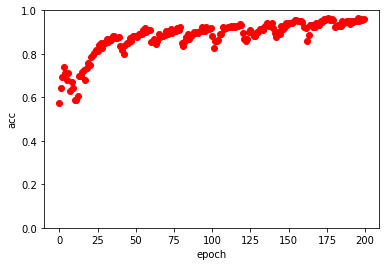

model save done


<Figure size 432x288 with 0 Axes>

In [ ]:
for epoch in range(args.epochs):
  print(f'training on batchs .. {epoch}/{args.epochs}')

  train_labels, train_predict, train_loss = train(dataloader, optimizer, cosineannealing_scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  logger.info("train_loss: %.5f - train_acc:%.5f" %(train_loss, train_acc))

  plt.ylim(0,1)
  plt.plot(epoch, train_acc,'or')
  plt.xlabel('epoch')
  plt.ylabel('acc')

plt.show()
plt.savefig(f'{path}/log/plot.png')

torch.save(model.state_dict(), f'{path}/model/titanic{today}_dict')
print("model save done")